# CODE REFERENCE:

1. https://github.com/SoftWiser-group/FTrojan
2. https://github.com/townblack/pytorch-cifar10-resnet18/tree/master

# Import and declarance 

In [1]:
import numpy as np
import torch
from data import get_data, poison
from torch.utils.data import DataLoader, TensorDataset
import torch.optim
from data import impose

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

2023-09-26 20:46:46.508499: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
torch.cuda.is_available()

True

In [3]:

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out

class cifar_model(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(cifar_model, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



# Codes below are for model loading and testing

In [4]:
from matplotlib import pyplot as plt

def tester():
    
    param = {
        "dataset": "CIFAR10",             # GTSRB, cifar10, MNIST, PubFig, ImageNet16
        "target_label": 8,              # target label
        "poisoning_rate": 0.02,         # ratio of poisoned samples
        "label_dim": 10,
        "channel_list": [1, 2],               # [0,1,2] means YUV channels, [1,2] means UV channels
        "magnitude": 20,
        "YUV": True,
        "clean_label": False,
        "window_size": 32,
        "pos_list": [(31, 31), (15, 15)],
    }
    x_train, y_train, x_test, y_test = get_data(param)
    #print(x_train)
    x_test_pos = impose(x_test.copy(), y_test.copy(), param)
    y_test_pos = np.array([param["target_label"]] * x_test_pos.shape[0], dtype=np.long)

    #Codes below used to show comparison example
    sample_index=12

    sample_img=(x_test[sample_index]*255).astype(np.uint8)
    sample_img_pos=(x_test_pos[sample_index]*255).astype(np.uint8)
    sample_img_diff=sample_img-sample_img_pos

    plt.imshow(sample_img)
    plt.title("original")
    plt.show()
    plt.imshow(sample_img_pos)
    plt.title("poisoned")
    plt.show()
    plt.imshow(sample_img_diff)
    plt.title("trigger")
    plt.show()

    #logically, the test function the original repo used logically maybe unsuitable(caused by ignoring rounding error)(?)
    x_test_pos=((x_test_pos*255).astype(np.uint8)).astype(np.float)/255

    x_test, x_test_pos =np.transpose(x_test, (0, 3, 1, 2)), np.transpose(x_test_pos, (0, 3, 1, 2))

    x_test, y_test = torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long).view((-1, ))
    x_test_pos, y_test_pos = torch.tensor(x_test_pos, dtype=torch.float), torch.tensor(y_test_pos, dtype=torch.long).view((-1, ))

    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=False)
    test_pos_loader = DataLoader(TensorDataset(x_test_pos, y_test_pos), batch_size=64, shuffle=False)

    model = torch.load("poisonedModel.pt")
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    correct = 0.0
    total = 0.0
    batch_idx = 0
    model.eval()
    with torch.no_grad():
        for (batch_x, batch_y) in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            total_loss += loss
            batch_idx += 1
        print("Benign Accuracy Evaluation - Epoch: {}, Loss: {:.4}, Accuracy: {:.4}".format(0, total_loss / batch_idx, 100 * correct / total))

    total_loss = 0.0
    correct = 0.0
    total = 0.0
    batch_idx = 0
    with torch.no_grad():
        for (batch_x, batch_y) in test_pos_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)

            correct += (predicted == batch_y).sum().item()
            
            total_loss += loss
            batch_idx += 1
        print("Attack Success Rate Evaluation - Epoch: {}, Loss: {:.4}, Accuracy: {:.4}\n".format(0, total_loss / batch_idx, 100 * correct / total))

/tmp/ipykernel_10885/1474743225.py:20: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test_pos = np.array([param["target_label"]] * x_test_pos.shape[0], dtype=np.long)


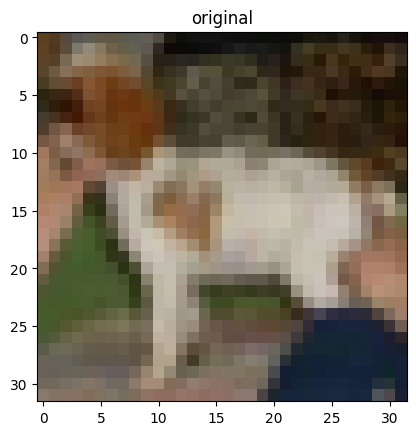

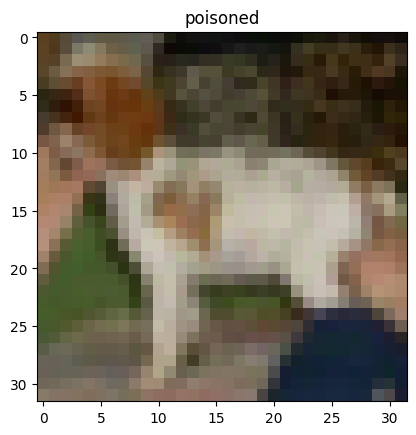

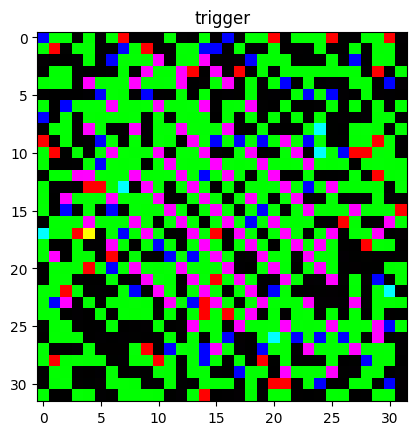

/tmp/ipykernel_10885/1474743225.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test_pos=((x_test_pos*255).astype(np.uint8)).astype(np.float)/255


Benign Accuracy Evaluation - Epoch: 0, Loss: 0.7974, Accuracy: 85.27
Attack Success Rate Evaluation - Epoch: 0, Loss: 0.02692, Accuracy: 99.41



In [5]:
tester()